In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/12 12:23:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/home/ec2-user/pyspark_streaming/lib64/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

In [ ]:
query = transactions.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

query.awaitTermination()

In [ ]:
query.stop()

For your use case, you only need to start the Kafka stream once. The `transactions` DataFrame you defined will continuously read the data from Kafka. Each of your transformation operations (like aggregations, filtering, etc.) will then be applied to this `transactions` DataFrame.

However, when you want to view the results of these transformations, you have to initiate separate streaming queries for each operation. The key is to define these transformations as separate queries from the initial stream read.

Here’s how you can structure this:

1. **Start the Kafka Stream**: Run this block once to initialize the streaming DataFrame from Kafka.

   ```python
   transactions = (df.selectExpr("CAST(value AS STRING)")
                   .withColumn("data", from_json(col("value"), schema))
                   .select("data.*"))
   ```

2. **Apply Transformations and View Results**: For each transformation, you'll create a new streaming query. Here's how you would modify the provided examples to view their output:

   **Example - Total Transaction Amounts by Store Location**:

   ```python
   total_amounts_by_location = transactions.groupBy("store_location")\
                                           .agg(_sum("transaction_amount").alias("total_amount"))

   query_total_amounts = total_amounts_by_location.writeStream \
       .outputMode("complete") \
       .format("console") \
       .start()

   query_total_amounts.awaitTermination()
   ```

   You would replicate this pattern for each of your other transformations, creating separate queries and viewing their results independently.

3. **Managing Multiple Streams**: If you start multiple queries like this, each will output to the console independently. To view only the output of a specific transformation, you should stop other active queries using `query.stop()` before starting a new one.

4. **Note on `.awaitTermination()`**: Be aware that `query.awaitTermination()` will block the current thread until the stream query stops, which means you won't be able to run other code in the same notebook or script while the query is active. If you're experimenting in a Jupyter Notebook, you might want to remove the `.awaitTermination()` call and rely on the notebook's interactive environment to manage the stream's lifecycle. Alternatively, for long-running streams or automated scripts, `.awaitTermination()` is appropriate.

By structuring your Jupyter Notebook this way, you can effectively manage multiple transformations on your Kafka stream and view each transformation's output independently.

1. Transformations:
Aggregations:

Total transaction amounts by store location.

In [ ]:
from pyspark.sql.functions import sum as _sum

total_amounts_by_location = transactions.groupBy("store_location")\
                                        .agg(_sum("transaction_amount").alias("total_amount"))

query_total_amounts = total_amounts_by_location.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_total_amounts.awaitTermination()


In [ ]:
# After viewing results from above snippet, and when we are ready to stop the stream...

query_total_amounts.stop()

Task 1.2: Number of transactions by store location.

In [ ]:
num_transactions_by_location = transactions.groupBy("store_location")\
                                           .count()\
                                           .withColumnRenamed("count", "num_transactions")

query_num_transactions = num_transactions_by_location.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_num_transactions.awaitTermination()

In [ ]:
query_num_transactions.stop()

Task 1.3: Average Transaction Amount by Store Location

In [ ]:
from pyspark.sql.functions import avg

avg_transaction_amount_by_location = transactions.groupBy("store_location")\
                                                 .agg(avg("transaction_amount").alias("avg_transaction_amount"))

query_avg_transaction_amount = avg_transaction_amount_by_location.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_avg_transaction_amount.awaitTermination()

In [ ]:
query_avg_transaction_amount.stop()

2. Time Series Analysis
2.1 Transactions per Hour/Day

In [ ]:
from pyspark.sql.functions import hour, dayofmonth

transactions_per_hour = transactions.withColumn("hour", hour("time_of_purchase"))\
                                    .groupBy("hour")\
                                    .count()\
                                    .withColumnRenamed("count", "transactions_per_hour")

query_transactions_per_hour = transactions_per_hour.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_transactions_per_hour.awaitTermination()

In [ ]:
query_transactions_per_hour.stop()

In [ ]:
transactions_per_day = transactions.withColumn("day", dayofmonth("time_of_purchase"))\
                                   .groupBy("day")\
                                   .count()\
                                   .withColumnRenamed("count", "transactions_per_day")

query_transactions_per_day = transactions_per_day.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_transactions_per_day.awaitTermination()

In [ ]:
query_transactions_per_day.stop()

2.2 Total or Average Transaction Amounts Over Time

In [ ]:
from pyspark.sql.functions import sum as _sum

total_amounts_over_time = transactions.groupBy(dayofmonth("time_of_purchase").alias("day"))\
                                      .agg(_sum("transaction_amount").alias("total_amount"))

query_total_amounts_over_time = total_amounts_over_time.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_total_amounts_over_time.awaitTermination()

In [ ]:
query_total_amounts_over_time.stop()

In [ ]:
avg_amounts_over_time = transactions.groupBy(dayofmonth("time_of_purchase").alias("day"))\
                                    .agg(avg("transaction_amount").alias("avg_amount"))

query_avg_amounts_over_time = avg_amounts_over_time.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_avg_amounts_over_time.awaitTermination()

In [ ]:
query_avg_amounts_over_time.stop()

3. Product Analysis
Top N Products by Number of Transactions

In [ ]:
top_n_products_by_transactions = transactions.groupBy("product_ID")\
                                             .count()\
                                             .withColumnRenamed("count", "num_transactions")\
                                             .orderBy(col("num_transactions").desc())

query_top_n_products_transactions = top_n_products_by_transactions.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_top_n_products_transactions.awaitTermination()

In [ ]:
query_top_n_products_transactions.stop()

3.2 Top N Products by Total Transaction Amount

In [ ]:
top_n_products_by_total_amount = transactions.groupBy("product_ID")\
                                             .agg(_sum("transaction_amount").alias("total_transaction_amount"))\
                                             .orderBy(col("total_transaction_amount").desc())

query_top_n_products_total_amount = top_n_products_by_total_amount.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_top_n_products_total_amount.awaitTermination()

In [ ]:
query_top_n_products_total_amount.stop()

4. Anomaly Detection
Identify Transactions with Amounts Significantly Different from the Average

--

The error you're encountering, "AnalysisException: Queries with streaming sources must be executed with writeStream.start(); kafka", indicates that there is an issue with how you're attempting to process the streaming data from Kafka. This error typically occurs when you're trying to use an action (like `.show()`, `.collect()`, etc.) that is meant for batch processing on a streaming DataFrame.

In your case, the issue seems to be arising from these lines:

```python
std_dev = transactions.agg(stddev("transaction_amount").alias("stddev_amount")).collect()[0]["stddev_amount"]
avg_amount = transactions.agg(avg("transaction_amount").alias("avg_amount")).collect()[0]["avg_amount"]
```

In a streaming context, you cannot directly use actions such as `collect()` on a streaming DataFrame, since it represents an unbounded dataset. The standard aggregation functions and actions like `collect()` are designed for batch DataFrames where the dataset is finite and fully available at the time of computation.

To work around this, you need to define your anomaly detection logic within the streaming query itself, and then start the query with `writeStream`. However, calculating a standard deviation or average in real-time over a streaming dataset can be complex and may require using stateful operations or windowed aggregations.

Here's an alternative approach using windowed aggregations for streaming data:

```python
from pyspark.sql.functions import window, stddev, avg

# Windowed aggregation for streaming data
windowed_transactions = transactions \
    .withColumn("window", window("time_of_purchase", "1 hour")) \
    .groupBy("window") \
    .agg(
        stddev("transaction_amount").alias("stddev_amount"),
        avg("transaction_amount").alias("avg_amount")
    )

# You can then start the stream to write the results to the console
query_windowed_transactions = windowed_transactions.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_windowed_transactions.awaitTermination()
```

This code snippet uses a tumbling window of 1 hour to calculate the standard deviation and average of transaction amounts. Each window will be processed independently. Remember that in a streaming context, especially with windowed aggregations, your results are calculated over the data in the respective windows and not over the entire dataset.

In [ ]:
from pyspark.sql.functions import window, stddev, avg

# Windowed aggregation for streaming data
windowed_transactions = transactions \
    .withColumn("window", window("time_of_purchase", "1 hour")) \
    .groupBy("window") \
    .agg(
        stddev("transaction_amount").alias("stddev_amount"),
        avg("transaction_amount").alias("avg_amount")
    )

# You can then start the stream to write the results to the console
query_anomalous_transactions = windowed_transactions.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query_anomalous_transactions.awaitTermination()

In [34]:
query_anomalous_transactions.stop()

-------------------------------------------
Batch: 26
-------------------------------------------
+--------------------+------------------+-----------------+
|              window|     stddev_amount|       avg_amount|
+--------------------+------------------+-----------------+
|{2023-12-12 09:00...|359.34876686639353|452.1512605042017|
+--------------------+------------------+-----------------+



5. Filtering
Filter Transactions Below or Above a Certain Amount

In [ ]:
filtered_transactions = transactions.filter((col("transaction_amount") > 50) & 
                                            (col("transaction_amount") < 1000))

query_filtered_transactions = filtered_transactions.writeStream \
    .outputMode("update") \
    .format("console") \
    .start()

query_filtered_transactions.awaitTermination()

In [8]:
query_filtered_transactions.stop()

# 2. Plots/Visualizations
- Bar Plots:
    - 2.1. **Total transaction amounts by store location.**
    - 2.2. Number of transactions by store location.
    - 2.3. Top N products by the number of transactions or transaction amounts.

---

Creating visualizations like bar plots for streaming data using Matplotlib in a Jupyter Notebook involves a few extra steps compared to handling static data. The main challenge is that streaming data is continuously updating, and typical plotting libraries like Matplotlib are not designed for dynamically updating visualizations out-of-the-box.

However, you can create periodic snapshots of the streaming data, collect the required data points for the plot, and then visualize them. Here’s a basic way to do this:

Step 1: Define the Streaming Queries

First, define the streaming queries to calculate the aggregates you need. For example, total transaction amounts by store location:

In [5]:
from pyspark.sql.functions import sum as _sum

total_amounts_by_location_stream = transactions.groupBy("store_location")\
                                               .agg(_sum("transaction_amount").alias("total_amount"))

query_total_amounts = total_amounts_by_location_stream.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("total_amounts_by_location") \
    .start()

# Note: We're using .format("memory") and .queryName("...") to allow the streaming data to be queried as a static DataFrame using SQL.

23/12/12 12:23:48 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-5de555ea-77d7-438e-918e-8d71fdce5757. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/12 12:23:48 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


23/12/12 12:23:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Step 2: Periodically Query the Results and Plot

Now, you can periodically run a cell in your Jupyter Notebook to query the results and plot them:

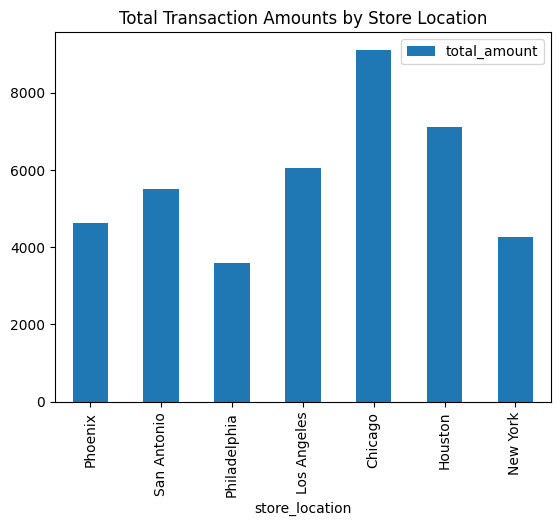

In [8]:
import time
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot the results
def plot_streaming_df(query_name, title, x_label, y_label):
    # Wait a bit for the streaming computation to produce some data
    time.sleep(5)  # Adjust the sleep time as needed

    # Fetch the result into a static DataFrame
    result_df = spark.sql(f"SELECT * FROM {query_name}")

    # Check if the DataFrame is empty
    if result_df.count() > 0:
        # Convert to Pandas DataFrame for plotting
        result_pdf = result_df.toPandas()

        # Create the plot
        result_pdf.plot(kind='bar', x=x_label, y=y_label)
        plt.title(title)
        plt.show()
    else:
        print("No data available for plotting.")

# Example: Plot total transaction amounts by store location
plot_streaming_df("total_amounts_by_location", "Total Transaction Amounts by Store Location", "store_location", "total_amount")

In [ ]:
query_total_amounts.stop()

### Time Series Plots:

Transaction counts over time (hourly, daily).
**Total or average transaction amounts over time.**

---

Creating a time series plot for total or average transaction amounts over time in a PySpark environment requires an approach that takes into account the streaming nature of the data. Here's a step-by-step guide to achieve this, along with the code snippets:
1. Aggregate Data in the Stream

First, you need to perform the aggregation over your streaming data. Let's say we are interested in the daily average transaction amount.

In [14]:
from pyspark.sql.functions import window, avg

# Aggregate average transaction amount over each day
avg_transaction_daily = transactions.withColumn("day", window("time_of_purchase", "1 day"))\
                                    .groupBy("day")\
                                    .agg(avg("transaction_amount").alias("avg_amount"))

# Write the stream to in-memory table for later querying
query_avg_transaction_daily = avg_transaction_daily.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("avg_transaction_daily_view") \
    .start()

# Debugging version: write directly to console
# query_debug = avg_transaction_daily.writeStream \
#     .outputMode("complete") \
#     .format("console") \
#     .start()
# query_debug.awaitTermination(20)  # Run for a limited time
# query_debug.stop()


23/12/12 12:56:18 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-59affee5-ed50-4626-aa38-06d159118ffc. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/12 12:56:18 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/12 12:56:19 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


2. Fetch Data and Plot

For plotting, fetch data from the in-memory table and use Matplotlib to create the time series plot. Note that this is a snapshot at the time of fetching the data.

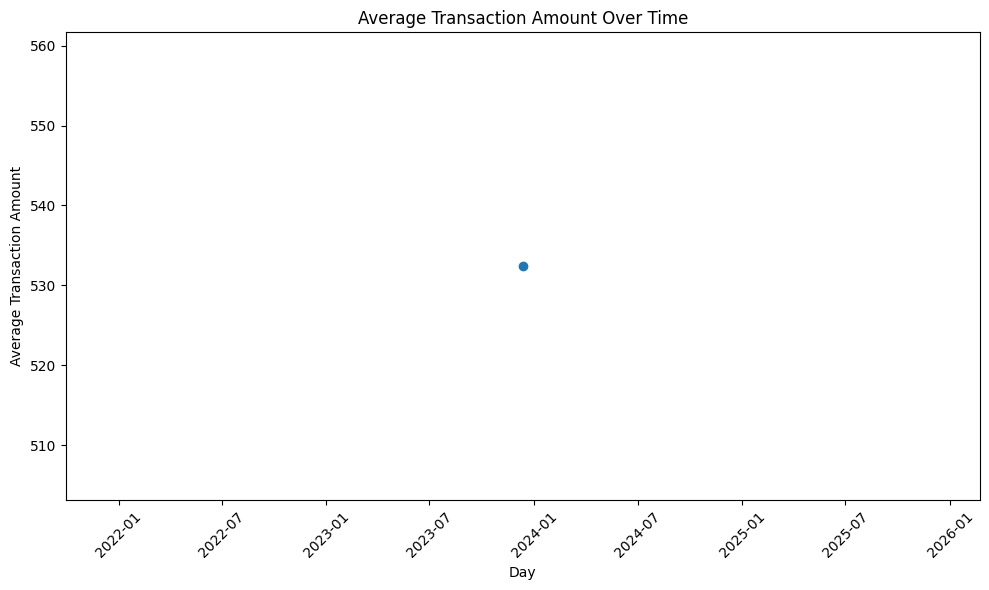

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import time

def plot_avg_transaction_daily():
    # Wait for a bit to allow data accumulation
    time.sleep(10)  # Adjust as needed

    # Fetch the result into a static DataFrame
    result_df = spark.sql("SELECT * FROM avg_transaction_daily_view")

    # Convert to Pandas DataFrame for plotting
    result_pdf = result_df.toPandas()

    if not result_pdf.empty:
        # Extract the 'start' timestamp from the 'day' StructType
        result_pdf['start'] = result_pdf['day'].apply(lambda row: row['start'])

        # Convert 'start' to datetime for plotting
        result_pdf['start'] = pd.to_datetime(result_pdf['start'])

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(result_pdf['start'], result_pdf['avg_amount'], marker='o')
        plt.title('Average Transaction Amount Over Time')
        plt.xlabel('Day')
        plt.ylabel('Average Transaction Amount')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for plotting.")

plot_avg_transaction_daily()

Note:
- The plot will represent a snapshot of the data up to the point when the data was queried.
- Adjust the time.sleep(10) to allow enough time for data to be processed and accumulated in the in-memory table. This value may need to be increased depending on the speed and volume of your data stream.
- This approach is suitable for an exploratory analysis in a Jupyter Notebook. For real-time or continuous visualization, more sophisticated solutions are needed.

In [18]:
query_avg_transaction_daily.stop()

### 3. Box Plots or Violin Plots:
Distribution of transaction amounts by store location to identify variability and outliers.

In [19]:
# Write transaction data to in-memory table
query_transactions_by_location = transactions.writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("transactions_by_location_view") \
    .start()


23/12/12 14:33:44 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-654841e6-b0e5-4828-9bdd-16141d919cf5. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/12 14:33:44 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


23/12/12 14:33:44 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


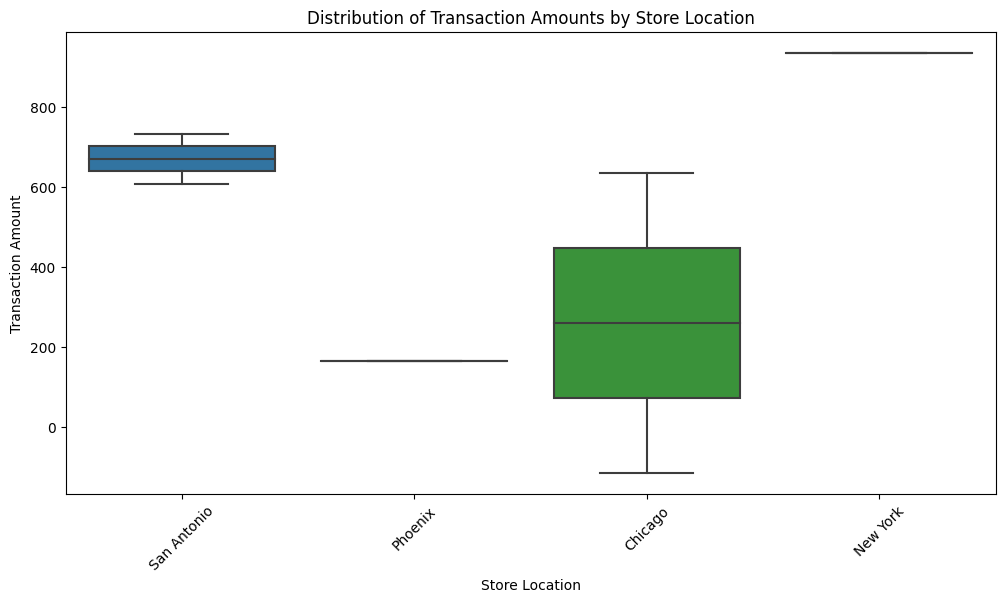

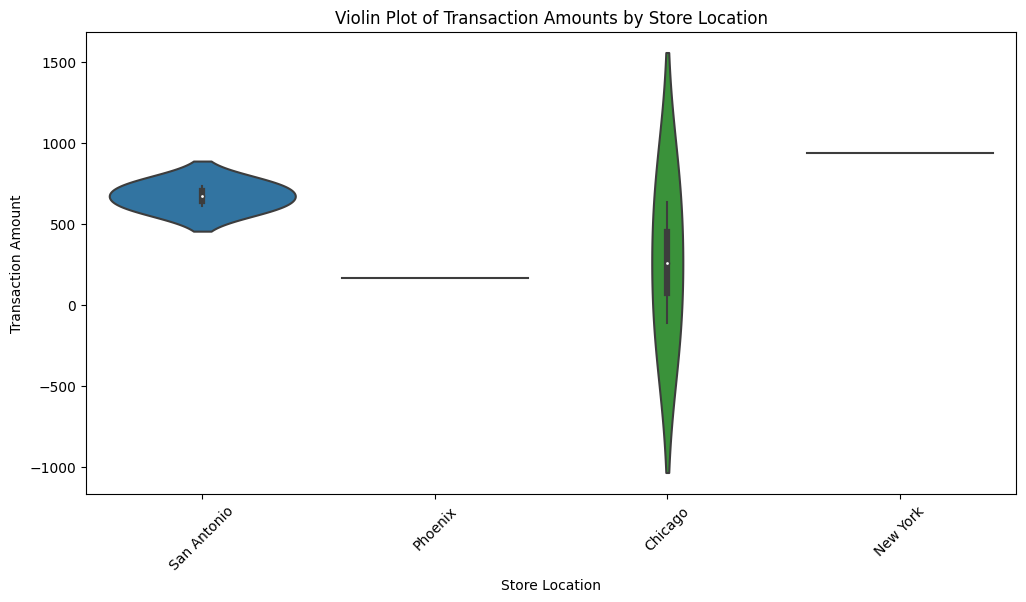

In [20]:
import seaborn as sns

def plot_transactions_distribution():
    # Wait for data to accumulate
    time.sleep(10)

    # Fetch the result into a static DataFrame
    result_df = spark.sql("SELECT store_location, transaction_amount FROM transactions_by_location_view")

    # Convert to Pandas DataFrame for plotting
    result_pdf = result_df.toPandas()

    if not result_pdf.empty:
        # Box Plot
        plt.figure(figsize=(12, 6))
        sns.boxplot(x="store_location", y="transaction_amount", data=result_pdf)
        plt.title('Distribution of Transaction Amounts by Store Location')
        plt.xlabel('Store Location')
        plt.ylabel('Transaction Amount')
        plt.xticks(rotation=45)
        plt.show()

        # Optionally, you can also create a violin plot
        plt.figure(figsize=(12, 6))
        sns.violinplot(x="store_location", y="transaction_amount", data=result_pdf)
        plt.title('Violin Plot of Transaction Amounts by Store Location')
        plt.xlabel('Store Location')
        plt.ylabel('Transaction Amount')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No data available for plotting.")

plot_transactions_distribution()


In [21]:
query_transactions_by_location.stop()

### 4. Heatmaps:

Hourly transaction counts for each store location over a week to identify peak times.

In [22]:
from pyspark.sql.functions import dayofweek, hour

# Aggregate transaction count by store location, day of the week, and hour
hourly_transaction_counts = transactions.groupBy("store_location", dayofweek("time_of_purchase").alias("day_of_week"), hour("time_of_purchase").alias("hour"))\
                                        .count()\
                                        .withColumnRenamed("count", "transaction_count")

# Write the stream to in-memory table
query_hourly_transactions = hourly_transaction_counts.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("hourly_transaction_counts_view") \
    .start()


23/12/12 14:39:58 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-dd5e97a0-d036-4542-af62-ab07c5c64603. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/12 14:39:58 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


23/12/12 14:39:58 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


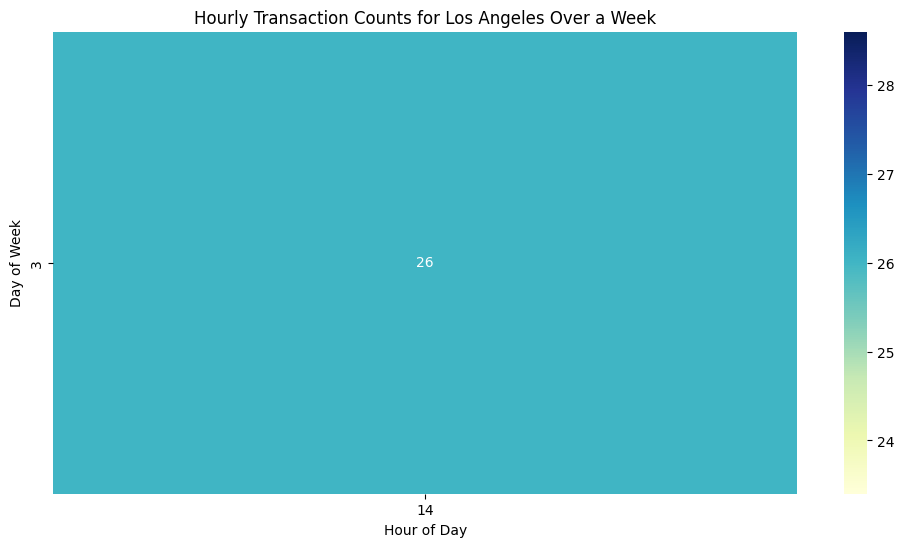

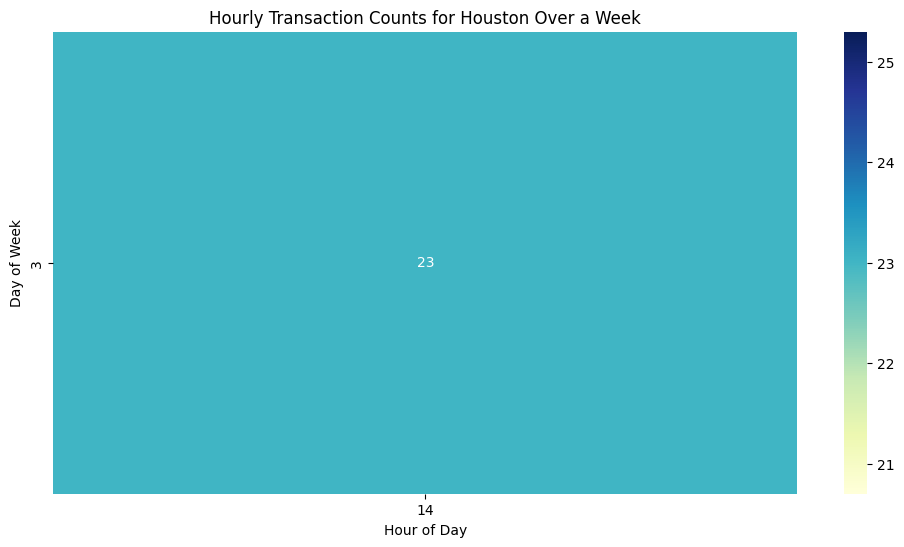

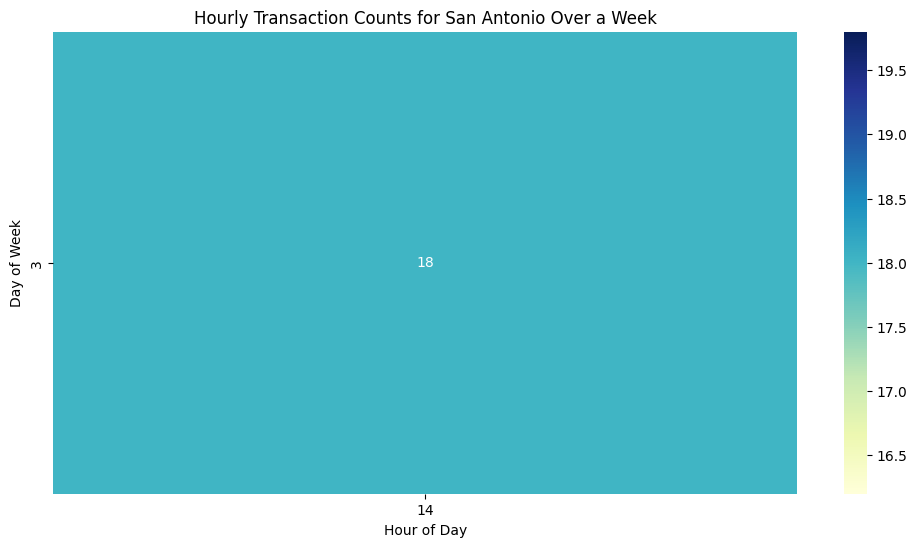

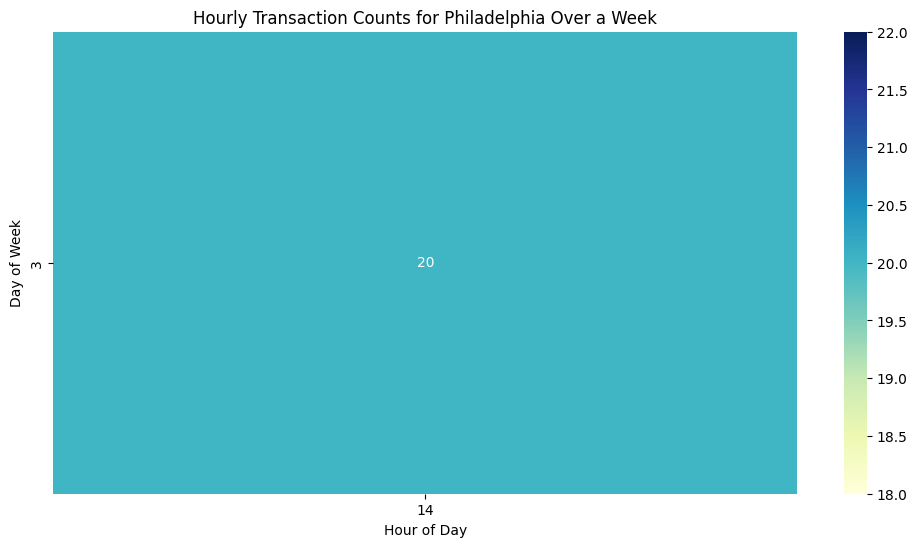

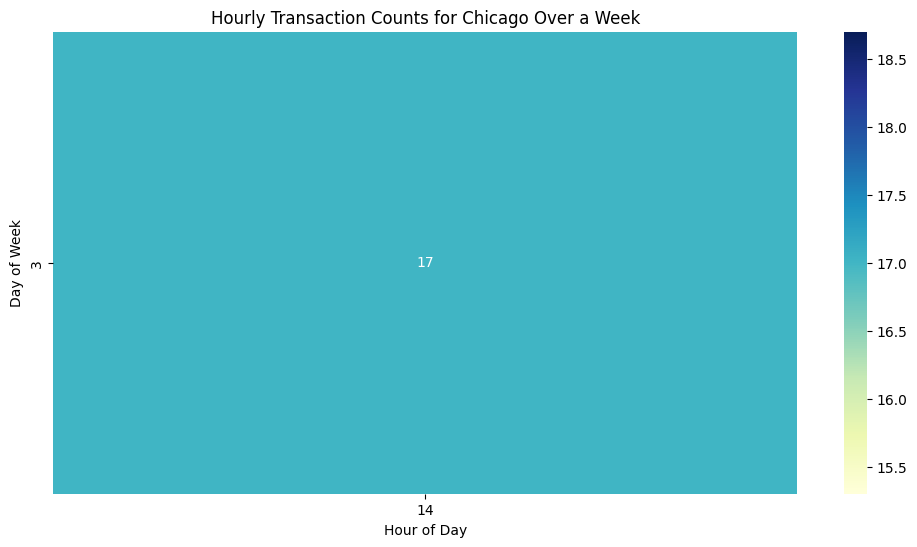

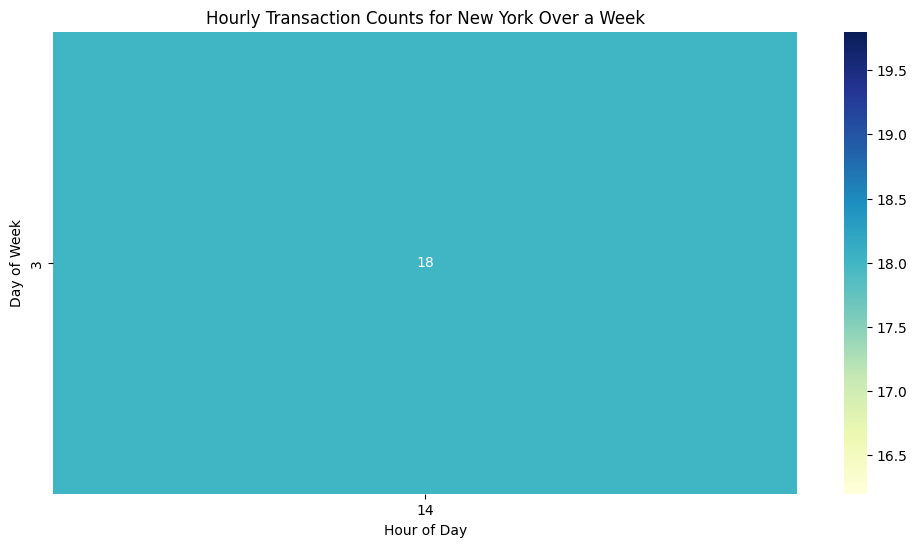

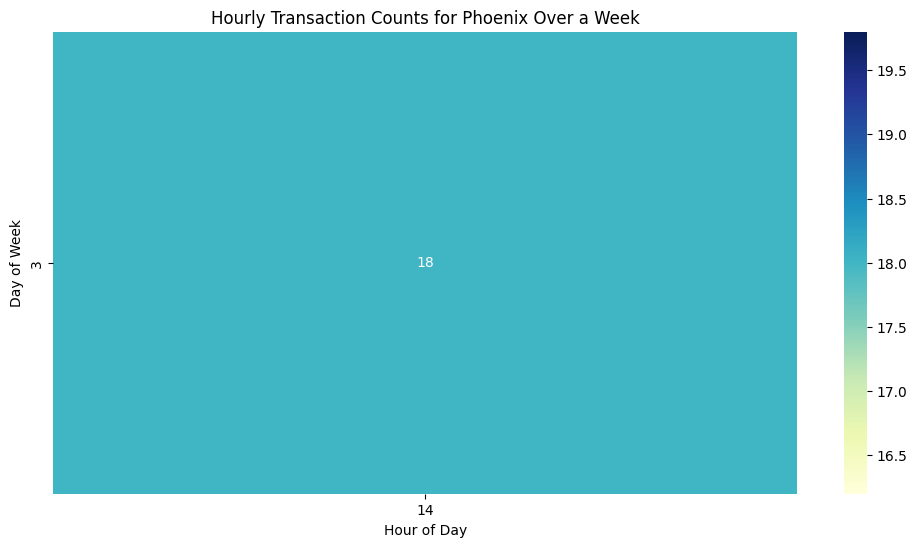

In [26]:
def plot_hourly_transaction_heatmap():
    # Wait for data to accumulate
    time.sleep(10)

    # Fetch the result into a static DataFrame
    result_df = spark.sql("SELECT * FROM hourly_transaction_counts_view")

    # Convert to Pandas DataFrame for plotting
    result_pdf = result_df.toPandas()

    if not result_pdf.empty:
        # Get unique store locations
        store_locations = result_pdf['store_location'].unique()

        # Plotting a heatmap for each store location
        for location in store_locations:
            location_df = result_pdf[result_pdf['store_location'] == location]
            heatmap_data = location_df.pivot("day_of_week", "hour", "transaction_count")
            heatmap_data = heatmap_data.sort_index(ascending=False)  # Optional: sort for better visualization

            plt.figure(figsize=(12, 6))
            sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
            plt.title(f'Hourly Transaction Counts for {location} Over a Week')
            plt.xlabel('Hour of Day')
            plt.ylabel('Day of Week')
            plt.show()
    else:
        print("No data available for plotting.")

plot_hourly_transaction_heatmap()

In [27]:
query_hourly_transactions.stop()